Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler as ss
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier

import warnings

warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('/datasets/car_data.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
data["DateCrawled"] = pd.to_datetime(data["DateCrawled"])
data["DateCreated"] = pd.to_datetime(data["DateCreated"])
data["LastSeen"] = pd.to_datetime(data["LastSeen"])

In [6]:
data.drop_duplicates(inplace=True)


In [7]:
print(data.isna().sum())

print(data.isnull().sum()/data.shape[0])


DateCrawled              0
Price                    0
VehicleType          37484
RegistrationYear         0
Gearbox              19830
Power                    0
Model                19701
Mileage                  0
RegistrationMonth        0
FuelType             32889
Brand                    0
NotRepaired          71145
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
DateCrawled          0.000000
Price                0.000000
VehicleType          0.105855
RegistrationYear     0.000000
Gearbox              0.056000
Power                0.000000
Model                0.055636
Mileage              0.000000
RegistrationMonth    0.000000
FuelType             0.092879
Brand                0.000000
NotRepaired          0.200914
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64


In [8]:
data['NotRepaired'].value_counts()


no     246927
yes     36035
Name: NotRepaired, dtype: int64

In [9]:
data['NotRepaired'].fillna('no', inplace=True)


In [10]:
for col in ['Model','VehicleType','FuelType']:
    data[col].fillna('n/a', inplace=True)    

In [11]:
data['Gearbox'].value_counts()


manual    268034
auto       66243
Name: Gearbox, dtype: int64

In [12]:
data['Gearbox'].fillna('manual', inplace=True)


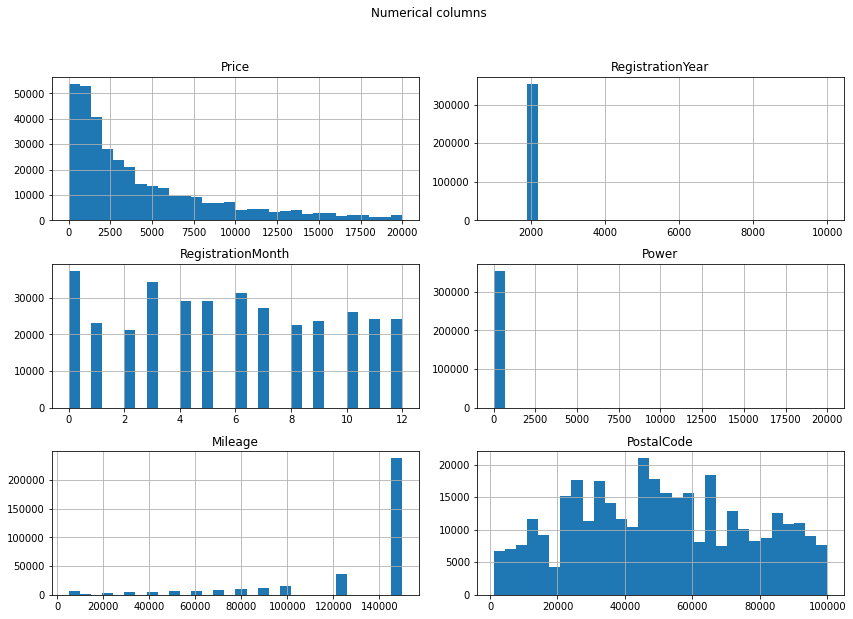

In [13]:
cols = ['Price', 'RegistrationYear', 'RegistrationMonth', 'Power', 'Mileage', 'PostalCode']
labels = [['Days since creation', 'Km/liter', 'PostalCode'], 
          ['BHP', 'EUR', 'Month'],
          ['Year']]
fig, ax = plt.subplots(figsize=(12, 9))
axes = data[cols].hist(bins=30, ax=ax)


plt.suptitle('Numerical columns')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Registration Year

Filtering for registrtion year less than 1900 and greater than 2016

In [14]:
data.loc[(data['RegistrationYear'] < 1900) | (data['RegistrationYear'] > 2016), 'RegistrationYear'] = np.nan


In [15]:
data = data.dropna(subset=['RegistrationYear'], axis=0)
data.reset_index(drop=True, inplace=True)

### Price



In [16]:
print(len(data[data['Price'] == 12345]))
print(len(data[data['Price'] == 1]))
print(len(data[data['Price'] == 0]))


7
1118
10006


In [17]:
data.loc[(data['Price'] == 12345) | (data['Price'] == 1) | (data['Price'] == 0), 'Price'] = np.nan


In [18]:
data = data.dropna(subset=['Price'], axis=0)
data.reset_index(drop=True, inplace=True)
data.shape

(328381, 16)

### Mileage
No edits will be made.

### Power
Remove observations with power higher than 2500 and also those equal to 0.

In [19]:
len(data[data['Power'] > 2500])
len(data[data['Power'] == 0])


32395

In [20]:
data.loc[(data['Power'] > 2500) | (data['Power'] == 0), 'Power'] = np.nan

data = data.dropna(subset=['Power'], axis=0)
data.reset_index(drop=True, inplace=True)
data.shape

(295901, 16)

### Car Age

Calculating


In [21]:
data['YearCreated'] = data['DateCreated'].dt.year


In [22]:
data['CarAge'] = data['YearCreated'] - data['RegistrationYear']


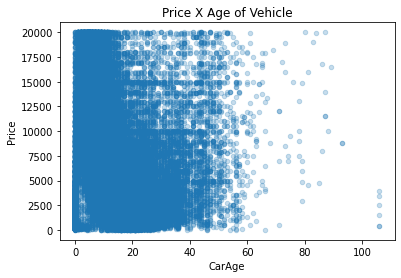

In [23]:
data.plot.scatter(x='CarAge', y='Price', alpha=.25)
plt.title('Price X Age of Vehicle');

# Encoding of categorical variables


In [24]:

data = data.drop(['PostalCode','DateCrawled','LastSeen','NumberOfPictures','RegistrationMonth',
                  'DateCreated','RegistrationYear', 'YearCreated'], axis=1)

In [25]:
data.head()


,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,CarAge
0,18300.0,coupe,manual,190.0,n/a,125000,gasoline,audi,yes,5.0
1,9800.0,suv,auto,163.0,grand,125000,gasoline,jeep,no,12.0
2,1500.0,small,manual,75.0,golf,150000,petrol,volkswagen,no,15.0
3,3600.0,small,manual,69.0,fabia,90000,gasoline,skoda,no,8.0
4,650.0,sedan,manual,102.0,3er,150000,petrol,bmw,yes,21.0


In [26]:
CatColumns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

oe = OrdinalEncoder()


In [27]:
data[CatColumns] = oe.fit_transform(data[CatColumns])


In [28]:
data.head()


,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,CarAge
0,18300.0,2.0,1.0,190.0,159.0,125000,2.0,1.0,1.0,5.0
1,9800.0,7.0,0.0,163.0,117.0,125000,2.0,14.0,0.0,12.0
2,1500.0,6.0,1.0,75.0,116.0,150000,7.0,38.0,0.0,15.0
3,3600.0,6.0,1.0,69.0,101.0,90000,2.0,31.0,0.0,8.0
4,650.0,5.0,1.0,102.0,11.0,150000,7.0,2.0,1.0,21.0


## Model training

In [29]:
X = data.drop(['Price'], axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=12345)
X_train.describe()



,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,CarAge
count,189376.000000,189376.000000,189376.000000,189376.000000,189376.000000,189376.000000,189376.000000,189376.000000,189376.000000
mean,4.986730,0.801348,121.546875,110.296252,128232.510983,5.352479,20.729496,0.097177,13.176860
std,2.448444,0.398987,65.529926,70.351253,36818.372231,2.267284,13.375272,0.296199,6.554675
min,0.000000,0.000000,1.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,1.000000,75.000000,42.000000,125000.000000,2.000000,9.000000,0.000000,9.000000
50%,5.000000,1.000000,111.000000,116.000000,150000.000000,7.000000,24.000000,0.000000,13.000000
75%,6.000000,1.000000,150.000000,167.000000,150000.000000,7.000000,33.000000,0.000000,17.000000
max,8.000000,1.000000,2402.000000,249.000000,150000.000000,7.000000,39.000000,1.000000,106.000000


In [30]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape


((189376, 9), (47344, 9), (59181, 9), (189376,), (47344,), (59181,))

#### Standard scaling


In [31]:
sc = ss()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

#### Function to determine RMSE & Model Parameters

In [32]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [33]:
def modeling(model, X_train, y_train, X_valid, y_valid, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(X_train, y_train)
    if model_str == 'catboost':
        gs.best_estimator_.fit(X_train, y_train, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(X_train, y_train)
    preds = gs.best_estimator_.predict(X_valid)
    best_rmse = rmse(y_valid, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

#### Linear Regression

In [34]:
linear = LinearRegression()
linearmodel, linearrmse, lineartime = modeling(linear, X_train, y_train, 
                                                        X_valid, y_valid,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=5, model_str='lr')

#### Random Forest Regressor

In [35]:
forest = RandomForestRegressor(random_state=42)
forestmodel, forestrmse, foresttime = modeling(forest, X_train, y_train, 
                                                        X_valid, y_valid,
                                                        hyperparameters={'n_estimators': [20, 30, 40, 50]}, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=5)

In [36]:
data

,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,CarAge
0,18300.0,2.0,1.0,190.0,159.0,125000,2.0,1.0,1.0,5.0
1,9800.0,7.0,0.0,163.0,117.0,125000,2.0,14.0,0.0,12.0
2,1500.0,6.0,1.0,75.0,116.0,150000,7.0,38.0,0.0,15.0
3,3600.0,6.0,1.0,69.0,101.0,90000,2.0,31.0,0.0,8.0
4,650.0,5.0,1.0,102.0,11.0,150000,7.0,2.0,1.0,21.0
...,...,...,...,...,...,...,...,...,...,...
295896,5250.0,3.0,0.0,150.0,4.0,150000,5.0,0.0,0.0,0.0
295897,3200.0,5.0,1.0,225.0,140.0,150000,7.0,30.0,1.0,12.0
295898,1199.0,1.0,0.0,101.0,106.0,125000,7.0,32.0,0.0,16.0
295899,9200.0,0.0,1.0,102.0,224.0,150000,2.0,38.0,0.0,20.0


#### Catboost 

In [37]:
cat = CatBoostRegressor(learning_rate=0.9, loss_function='RMSE',
                        random_seed=42)
catbmodel, catbrmse, catbtime = modeling(cat, X_train, y_train, 
                                                        X_valid, y_valid,
                                                        hyperparameters={'iterations': [20, 30, 40, 50]}, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=5, model_str='catboost')

0:	learn: 2682.1717222	total: 85.2ms	remaining: 1.62s
1:	learn: 2369.5100829	total: 120ms	remaining: 1.08s
2:	learn: 2239.9767077	total: 153ms	remaining: 868ms
3:	learn: 2146.5946769	total: 184ms	remaining: 736ms
4:	learn: 2094.0742739	total: 211ms	remaining: 632ms
5:	learn: 2060.8652525	total: 237ms	remaining: 552ms
6:	learn: 2011.7872170	total: 265ms	remaining: 492ms
7:	learn: 1973.7245861	total: 294ms	remaining: 441ms
8:	learn: 1947.9110919	total: 323ms	remaining: 395ms
9:	learn: 1927.3582266	total: 350ms	remaining: 350ms
10:	learn: 1902.6414018	total: 378ms	remaining: 309ms
11:	learn: 1891.2066072	total: 404ms	remaining: 270ms
12:	learn: 1878.4078847	total: 433ms	remaining: 233ms
13:	learn: 1865.7314319	total: 456ms	remaining: 195ms
14:	learn: 1854.8129634	total: 482ms	remaining: 161ms
15:	learn: 1845.9347887	total: 512ms	remaining: 128ms
16:	learn: 1838.7109793	total: 537ms	remaining: 94.8ms
17:	learn: 1827.2466787	total: 565ms	remaining: 62.7ms
18:	learn: 1816.3189234	total: 592m

In [38]:
modelperformance = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
              'best_rmse': [linearrmse, forestrmse, catbrmse],
              'train_time': [lineartime, foresttime, catbtime]})

In [39]:
modelperformance


,model,best_rmse,train_time
0,LinearRegression,3191.242180,1.02
1,RandomForestRegressor,1602.054472,391.33
2,CatBoostRegressor,1736.553629,40.49


## Model analysis

In [40]:
def valid_prediction(model, X_valid, y_valid):
    start_time = time.time()
    preds = model.predict(X_valid)
    return np.round(time.time(), 2) - start_time, rmse(y_valid, preds)

In [41]:

models = [linearmodel, forestmodel, catbmodel]
for model in models:
    pred_time, best_rmse = valid_prediction(model, X_valid, y_valid)
    print(f'RMSE is {best_rmse} while time to predict was {pred_time} seconds')

RMSE is 3191.2421804656074 while time to predict was 0.009097814559936523 seconds
RMSE is 1602.0544719195827 while time to predict was 1.140017032623291 seconds
RMSE is 1736.5536294029623 while time to predict was 0.005040645599365234 seconds


## Final Model Performance

In [42]:
def test_prediction(model, X_test, y_test):
    start_time = time.time()
    preds = model.predict(X_test)
    return np.round(time.time(), 2) - start_time, rmse(y_test, preds)


models = [forestmodel]
for model in models:
    pred_time, best_rmse = valid_prediction(model, X_test, y_test)
    print(f'RMSE is {best_rmse} while time to predict was {pred_time} seconds')

RMSE is 1598.6369351322476 while time to predict was 1.3252840042114258 seconds


# Conclusion

During this project I followed a lot of steps. First, I imported the data set and analyzed it. We created new datatypes, filled missing values and fixed ones with errors. 
I then encoded categorical variables. After that I split the data into test,train, and valid sets.
I then implemented standard scaling.
While selecting models I chose to compare Linear Regression, Random Forest and Catboost models.
RandomForestRegressor displays the best RMSE at 1598 but the time to predict landed at 1.3 seconds.

